References:

Logistic regression: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ROC curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Controlling the threshold in Logistic Regression in Scikit Learn: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

sklearn.metrics.precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


# Preprocessing

In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools
from collections import Counter
from scipy import interp
from indra.tools import assemble_corpus as ac
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib notebook


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load and preprocess the KGE/curation dataset
with open('kge_dataset.pkl', 'rb') as f:
    kge_dataset = pickle.load(f)
kge_df = pd.DataFrame.from_records(kge_dataset)
kge_df = kge_df.fillna(0)
# Every column except agent names and stmt type should be int
dtype_dict = {col: 'int64' for col in kge_df.columns
              if col not in ('agA_name', 'stmt_type', 'agB_name')}
kge_df = kge_df.astype(dtype_dict)
kge_df.head()

,stmt_num,stmt_hash,agA_name,stmt_type,agB_name,correct,medscan,reach,sparser,rlimsp,trips,hprd,isi,biopax,bel,signor,trrust
0,0,28616404731074564,TGFB1,Activation,MAPK3,1,17,3,3,0,0,0,0,0,0,0,0
1,1,34133827417313284,TP53,IncreaseAmount,NKX2-1,0,0,6,0,0,0,0,0,0,0,0,0
2,2,2587683760588810,DACT2,Complex,CTNNB1,1,1,4,2,0,0,0,0,0,0,0,0
3,4,-20297417063899124,LRRK2,Phosphorylation,EIF4EBP1,1,1,11,13,10,0,0,0,0,0,0,0
4,5,-31679163966597107,IGF1,Activation,ERK,1,16,98,29,0,8,0,0,0,0,0,0


# Visualizing the data

<IPython.core.display.Javascript object>


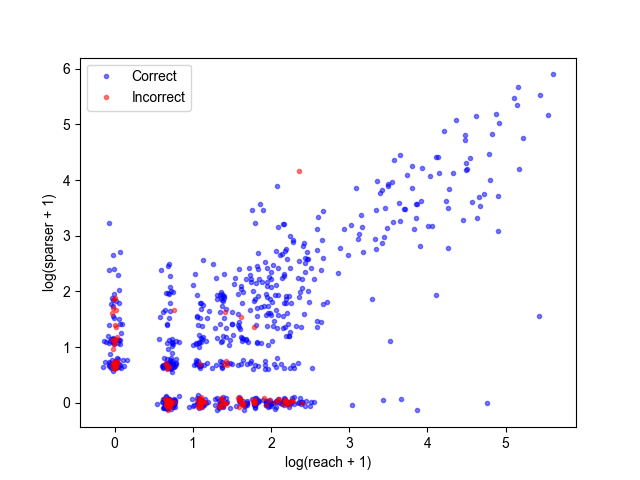

INFO: [2020-09-25 17:57:23] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2020-09-25 17:57:23] numexpr.utils - NumExpr defaulting to 8 threads.


In [3]:
plt.figure()

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
reader1 = 'reach'
reader2 = 'sparser'

kge_cp = kge_df.copy()
kge_cp  = kge_cp[(kge_df[reader1] > 0) | (kge_df[reader2] > 0)]
kge_cp[reader1] = np.log(kge_df[reader1] + 1)
kge_cp[reader2] = np.log(kge_df[reader2] + 1)

kge_incorr = kge_cp[kge_cp['correct'] == 0]
kge_corr = kge_cp[kge_cp['correct'] == 1]

plt.plot(rand_jitter(kge_corr[reader1]),
         rand_jitter(kge_corr[reader2]), linestyle='', marker='.',
         color='blue', alpha=0.5, label='Correct')
plt.plot(rand_jitter(kge_incorr[reader1]),
         rand_jitter(kge_incorr[reader2]), linestyle='', marker='.',
                     color='red', alpha=0.5, label='Incorrect')
plt.xlabel(f'log({reader1} + 1)')
plt.ylabel(f'log({reader2} + 1)')
plt.legend(loc='upper left')

In [ ]:
source_cols = ['medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
               'biopax', 'bel', 'signor', 'trrust']
reader = 'reach'
source_cols.pop(source_cols.index(reader))
# Reader only dataframe
ro_df = kge_df[~kge_df[source_cols].any(axis=1)]
x = list(range(1, 11))
r_only = []
r_all = []
r_only_cts = []
r_all_cts = []

def stderrp(p, n):
    pa = np.array(p)
    na = np.array(n)
    return(np.sqrt((pa*(1-pa))/na))

for i in x:
    lb = i
    if i < 10:
        ub = i+1
    else:
        ub = 10000
        
    r_only_rows = ro_df[(ro_df[reader] >= lb) & (ro_df[reader] < ub)]
    r_only.append(r_only_rows['correct'].mean())
    r_only_cts.append(len(r_only_rows['correct']))
    r_all_rows = kge_df[(kge_df[reader] >= lb) & (kge_df[reader] < ub)]
    r_all.append(r_all_rows['correct'].mean())
    r_all_cts.append(len(r_all_rows['correct']))
    
plt.figure()
plt.errorbar(x, r_only, linestyle='', yerr=stderrp(r_only, r_only_cts), marker='o', color='r', label=f'{reader} only')
plt.errorbar(x, r_all, linestyle='', yerr=stderrp(r_all, r_all_cts), marker='o', color='b', label=f'{reader} any')
plt.legend(loc='lower left')
plt.ylabel('Precision')
plt.xlabel(f'Num. of {reader}-only evidences')
plt.ylim([0, 1])


# Examining probabilities and assumptions

In [4]:
r1 = 'reach'
r2 = 'sparser'
r3 = 'sparser'

# Convert counts and correct into boolean variables
dtype_dict = {col: 'bool' for col in kge_df.columns
              if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
bin_df = kge_df.astype(dtype_dict)
dtype_dict = {col: 'int64' for col in kge_df.columns
              if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
bin_df = bin_df.astype(dtype_dict)
#bin_df_sub = bin_df[(bin_df[r1] > 0) | (bin_df[r2] > 0)]
#bin_df_sub = bin_df[(bin_df[r1] > 0) | (bin_df[r2] > 0) | (bin_df[r3] > 0)]
bin_df_sub = bin_df
bin_df_sub.head()

,stmt_num,stmt_hash,agA_name,stmt_type,agB_name,correct,medscan,reach,sparser,rlimsp,trips,hprd,isi,biopax,bel,signor,trrust
0,0,28616404731074564,TGFB1,Activation,MAPK3,1,1,1,1,0,0,0,0,0,0,0,0
1,1,34133827417313284,TP53,IncreaseAmount,NKX2-1,0,0,1,0,0,0,0,0,0,0,0,0
2,2,2587683760588810,DACT2,Complex,CTNNB1,1,1,1,1,0,0,0,0,0,0,0,0
3,4,-20297417063899124,LRRK2,Phosphorylation,EIF4EBP1,1,1,1,1,1,0,0,0,0,0,0,0
4,5,-31679163966597107,IGF1,Activation,ERK,1,1,1,1,0,1,0,0,0,0,0,0


In [5]:
bin_df_sub.corr()

,stmt_num,stmt_hash,correct,medscan,reach,sparser,rlimsp,trips,hprd,isi,biopax,bel,signor,trrust
stmt_num,1.000000,0.002233,0.000640,-0.032201,0.044611,0.008207,-0.017594,-0.073077,-0.001898,-0.013813,-0.009868,-0.029854,-0.064363,0.010059
stmt_hash,0.002233,1.000000,0.071221,0.011844,0.026335,0.109752,0.106569,-0.002421,-0.008343,-0.013807,0.043590,-0.010486,0.025688,0.004797
correct,0.000640,0.071221,1.000000,0.369241,0.161226,0.300249,0.135362,0.198552,0.157005,0.073490,0.106446,0.081996,0.130308,0.031781
medscan,-0.032201,0.011844,0.369241,1.000000,0.228863,0.333141,-0.043731,0.322052,0.236793,0.138013,0.016480,0.107998,0.124881,0.039329
reach,0.044611,0.026335,0.161226,0.228863,1.000000,0.143300,-0.142208,-0.139737,0.071675,0.035355,-0.030280,0.035122,0.032901,0.037085
sparser,0.008207,0.109752,0.300249,0.333141,0.143300,1.000000,0.131491,0.232273,0.222626,0.124464,0.098908,0.102867,0.118098,-0.071283
rlimsp,-0.017594,0.106569,0.135362,-0.043731,-0.142208,0.131491,1.000000,-0.150048,-0.091077,-0.084016,0.370785,-0.047833,0.122008,-0.036332
trips,-0.073077,-0.002421,0.198552,0.322052,-0.139737,0.232273,-0.150048,1.000000,0.201432,0.165541,-0.070246,0.148282,0.068670,0.011475
hprd,-0.001898,-0.008343,0.157005,0.236793,0.071675,0.222626,-0.091077,0.201432,1.000000,0.301695,0.058452,0.366944,0.298231,-0.022353
isi,-0.013813,-0.013807,0.073490,0.138013,0.035355,0.124464,-0.084016,0.165541,0.301695,1.000000,-0.033170,0.193928,0.103341,-0.009903


In [58]:
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0)]
#rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0) | (kge_df[r3] > 0)]
# Readers are same / 100% dependent
#rs_only_df[r2] = kge_df[r1]
# Readers are independent
#rs_only_df[r2] = rs_only_df[r2].sample(frac=1).values
#rs_only_df = kge_df

def prob(v, c=None, df=bin_df_sub):
    """Probability of variables v: vals conditioned on variables c: vals"""
    if c is None:
        c = []
    if not v:
        raise ValueError("v variables must be specified")
    c_df = df
    for c_var, c_val in c:
        c_df = c_df[c_df[c_var] == c_val]
    vc_df = None
    for v_var, v_val in v:
        if vc_df is None:
            vc_df = c_df[c_df[v_var] == v_val]
        else:
            vc_df = vc_df[vc_df[v_var] == v_val]
    return len(vc_df) / len(c_df)

In [59]:
# Test for conditional independence--is R1 independent of R2 given corr?
print(f"p({reader1} | {reader2}, corr)", prob([(r1, 1)], [(r2, 1), ('correct', 1)]))
print(f"p({reader1} | corr)", prob([(r1, 1)], [('correct', 1)]))
print()

# Are r1 and r2 independent?
print(f"p({reader1} and {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"p({reader1}) * p({reader2})", prob([(r1, 1)]) * prob([(r2, 1)]))
print()

print(f"Ground truth: p(corr, {reader1}, {reader2})", prob([('correct', 1), (r1, 1), (r2, 1)]))
print(f"Ground truth: p({reader1}, {reader2})", prob([(r1, 1), (r2, 1)]))
print(f"Ground truth: p(corr | {reader1}, {reader2})", prob([('correct', 1)], [(r1, 1), (r2, 1)]))
print(f"Assume corr CI of {reader1} given {reader2} = p(corr | {reader2})",
      prob([('correct', 1)], [(reader2, 1)]))


p(reach | sparser, corr) 0.8565310492505354
p(reach | corr) 0.7905138339920948

p(reach and sparser) 0.44136460554371004
p(reach) * p(sparser) 0.4107432681248039

Ground truth: p(corr, reach, sparser) 0.42643923240938164
Ground truth: p(reach, sparser) 0.44136460554371004
Ground truth: p(corr | reach, sparser) 0.966183574879227
Assume corr CI of reach given sparser = p(corr | sparser) 0.9174852652259332


In [60]:
# Both readers > 0
df = bin_df
print(r1, "only", len(df[(df[r1] > 0) & (df[r2] == 0)]))
print(r2, "only", len(df[(df[r2] > 0) & (df[r1] == 0)]))
print(r1, "and", r2, len(df[(df[r2] > 0) & (df[r1] > 0)]))
print("total", len(df))

reach only 296
sparser only 95
reach and sparser 414
total 938


In [61]:
# 1. The joint event
prob([('correct', 1), (r1, 1), (r2, 1)])

0.42643923240938164

In [62]:
# 2. By chain rule (exact vs above)
prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])

0.42643923240938164

In [63]:
# 3. What we want to know: p(c|r,s) (exact)
prob([('correct', 1)], [(r1, 1), (r2, 1)])

0.966183574879227

In [64]:
# 4. What we want to know, by defn of cond prob vs. above (exact)
prob([('correct', 1), (r1, 1), (r2, 1)]) / prob([(r1, 1), (r2, 1)]) #

0.9661835748792269

In [65]:
# 5 Applying chain rule (combining 2 and 4)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([(r2, 1)], [('correct', 1), (r1, 1)])) / 
     prob([(r1, 1), (r2, 1)]))

0.9661835748792269

In [66]:
# 6. Applying Bayes rule for p(r2|c,r1)
((prob([(r1, 1)]) * prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / 
     (prob([(r1, 1), (r2, 1)])*prob([('correct', 1)], [(r1, 1)])*prob([(r1, 1)])))

0.9661835748792269

In [67]:
# 7. Cancel terms * (Exact)
# p(c,r1|r2) * p(r2)
# ------------------
#      p(r1,r2)
exact = (prob([('correct', 1), (r1, 1)], [(r2, 1)]) * prob([(r2, 1)])) / (prob([(r1, 1), (r2, 1)]))
print("Exact:", exact)

# 8. Complete identity/correlation
redundant = prob([('correct', 1)], [(r2, 1)])
print("Redundant:", redundant)

# 9. Complete independence
indep = (prob([('correct', 1)], [(r1, 1)]) * prob([('correct', 1)], [(r2, 1)])) / prob([('correct', 1)])
print("Independent", indep)

# 10. Like coin flips
coins = 1 - (1 - prob([('correct', 1)], [(r1, 1)])) * (1 - prob([('correct', 1)], [(r2, 1)])) 
print("Joint belief:", coins)

# 8. Substituting approximation: p(c,r1|r2) = p(c|r2)*p(r1|r2)
# p(c|r2) * p(r1|r2) * p(r2)
# --------------------------
#      p(r1,r2)
#(prob(['correct'], [r2]) * prob([r1], [r2]) * prob([r2])) / (prob([r1, r2]))

# Full independence:
# p(c|r2) * p(r1) * p(r2)
# -------------------------- = p(c|r2)
#      p(r1) * p(r2)

# Full dependence:
# p(c|r2) * 1 * p(r2)
# --------------------------
#      p(r1,r2)

#((prob([r1]) * prob(['correct'], [r1]) * prob([r1], [r2]) * prob([r2])) / 
#     (prob([r1, r2])*prob(['correct'], [r1])*prob([r1])))

Exact: 0.9661835748792268
Redundant: 0.9174852652259332
Independent 0.9581931512352339
Joint belief: 0.9872160270068348


In [68]:
# An expression that we need.
# If only one reader, all rows will have at least one evidence from that reader, whether correct or not
prob([(r1, 1), (r2, 1)], [('correct', 1)])

0.5270092226613966

In [69]:
# Approximation of above - if readers are the same, this should be quite wrong; if independent, quite right
prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)])

0.4863899347487593

In [70]:
prob([(r1, 1)], [('correct', 1)])

0.7905138339920948

In [71]:
# Bayes rule vs p(r1,r2|c) - exact
(prob([('correct', 1)], [(r1, 1), (r2, 1)]) * prob([(r1, 1), (r2, 1)])) / prob([('correct', 1)])

0.5270092226613965

In [72]:
# Rearrange from above - exact
(prob([(r1, 1), (r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

0.9661835748792271

In [73]:
# Now, apply our assumption that p(r,s|c) ~= p(r|c)p(s|c)
# A hint in the fact that effectiveness of this changes when we filter dataset to statements with at least
# one of the two readers
(prob([(r1, 1)], [('correct', 1)]) * prob([(r2, 1)], [('correct', 1)]) * prob([('correct', 1)])) / prob([(r1, 1), (r2, 1)])

0.8917148803727254

In [74]:
prob([('correct', 1)])

0.8091684434968017

# Approximating the joint distribution

## Bahadur Lazarsfeld second order model

The notation/nomenclature in the functions below here is based on page 3 of "Estimation in second order dependency model for multivariate binary data", E.H.S. Ip. Link [here](https://statistics.stanford.edu/sites/g/files/sbiybj6031/f/OLK%20NSF%20302.pdf). 

In [75]:
class BLPredictor(object):
    def __init__(self, df=None, order=2):
        self.df = df
        self.order = order
        
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            joint_prob = self.bahadur_laz(col_vals, max_order=self.order)
            denom = prob(col_vals[:-1], df=self.df)
            pred_prob = joint_prob / denom
            if pred_prob > 1:
                pred_prob = 1.0
            elif pred_prob < 0:
                pred_prob = 0.
            self.prob_cache[x_vals] = pred_prob
        
    def predict_proba(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        for row_ix in range(x_arr.shape[0]):
            x_vals = x_arr[row_ix, :]
            # Get the computed value for this feature vector from the cache
            pred_prob = self.prob_cache[tuple(x_vals)]
            # If we didn't see it in training, we just fall back on p(correct)
            if pred_prob is np.nan: 
                pred_prob = prob([(len(x_vals)-1, self.y_target)], df=self.df)
            y_probs[row_ix, 0] = 1 - pred_prob
            y_probs[row_ix, 1] = pred_prob
        return y_probs
    
    def predict(self, x_arr, order=2, threshold=0.5):
        if x_arr.shape[1] != self.df.shape[1] - 1:
            raise ValueError("Prediction data is wrong shape.")
        y_probs = np.zeros((x_arr.shape[0], 2))
        y_preds = self.predict_proba(x_arr, order, threshold)
        for row_ix, pred_prob in enumerate(y_preds):
            if pred_prob[1] is np.nan:
                pred = np.nan
            else:
                pred = 0 if pred_prob[1] < threshold else 1
            y_preds[row_ix] = pred
        return y_preds

    # alpha(Yi) = E(Yi), i.e., probability Yi = 1, i.e., p in the usual notation for bernoulli variables.
    def alpha(self, col):
        return self.df[col].mean()

    # This function returns the probability  p(Y1 = y1, Y2=y2, Y3=y3...) etc. as the product of
    # the independent probabilities i.e., p(Y1=y1)*p(Y2=y2)*p(Y3=y3)*...
    def p1y(self, col_vals):
        prod = 1
        for col, val in col_vals:
            if val not in (0, 1):
                raise ValueError("Values must be 0 or 1")
            prod *= (self.alpha(col)**val) * (1 - self.alpha(col))**(1 - val)
        return prod

    # W has two senses in the notation used by Ip. If no value is given (val=None),
    # evaluates to (Yi - p)/sqrt(pq) = a standardized version of Yi (offset by the mean and divided by the SD).
    # If given a specific value yi (0 or 1), gives the standardized probability of yi.
    def W(self, col, val=None):
        a = self.alpha(col)
        denom = np.sqrt(a * (1 - a))
        if val is None:
            numer = (self.df[col] - a).values
        else:
            numer = val - a
        return numer / denom

    # Returns E(W1*W2*...*Wi). For the case of two variables Yi and Yj, r_ij = E(Wi*Wj) is
    # equivalent to the correlation between Yi and Yj.
    def r(self, cols):
        return np.mean(np.prod(np.stack([self.W(col) for col in cols]), axis=0))

    # For a set of values associated with variables, i.e., y1, y2, ... yn,
    # returns the product W(y1)*W(y2)*...*W(yn), i.e., the product of the normalized
    # probabilities of each Yi taking a specific value yi.
    def W_prod(self, col_vals):
        return np.prod([self.W(col, val) for col, val in col_vals])

    # Generates a term in the expansion of the given order. For order 2,
    # returns sum_(j<k) {rjk * Wj * Wk}, i.e., based on pairwise correlations.
    def term(self, col_vals, order):
        total = 0
        for col_val_combo in itertools.combinations(col_vals, order):
            r_term = self.r([col for col, val in col_val_combo])
            W_term = self.W_prod(col_val_combo)
            total += r_term * W_term
        return total

    def bahadur_laz(self, col_vals, max_order=2):
        fy = 1
        if max_order < 1 or max_order > len(self.df.columns):
            raise ValueError('max_order must be between 1 and len(col_vals)')
        for order in range(2, max_order+1):
            fy += self.term(col_vals, order)
        return self.p1y(col_vals) * fy    

    
class ProbPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Get the unique input vectors in x_train
        x_val_combos_in_data = set([tuple(x_train[ix, :]) for ix in range(x_train.shape[0])])
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            # If this combination doesn't actually occur, set to NaN in the cache and skip
            if x_vals not in x_val_combos_in_data:
                self.prob_cache[x_vals] = np.nan
                continue
            x_vect = list(x_vals) + [y_target]
            col_vals = list(zip(range(len(x_vect)), x_vect))
            pred_prob = prob(col_vals, col_vals[:-1], df=self.df)
            self.prob_cache[x_vals] = pred_prob
    
    
class BeliefPredictor(BLPredictor):
    def fit(self, x_train, y_train, y_target=1):
        data = np.column_stack([x_train, y_train])
        self.y_ix = data.shape[1]-1
        self.df = pd.DataFrame(data)
        self.prob_cache = {}
        self.y_target = y_target
        # Calculate the error probabilities for each reader column
        err_probs = {}
        for col_ix in range(self.df.shape[1]-1):
            err_probs[col_ix] = 1 - self.df[self.df[col_ix] == 1][self.y_ix].mean()
        # Here, we actually iterate over all combinations of input vectors and compute belief
        x_val_combos = list(itertools.product([0, 1], repeat=self.df.shape[1]-1))
        for x_vals in x_val_combos:
            total_err_prob = 1
            for col_ix, x_val in enumerate(x_vals):
                # Multiply by the error probabilities for any readers with evidence
                if x_val == 1:
                    total_err_prob *= err_probs[col_ix]
            pred_prob = 1 - total_err_prob
            self.prob_cache[x_vals] = pred_prob

In [76]:
# p(R1=1, R2=1, corr=1)
r1 = 'reach'
r2 = 'sparser'
r3 = 'medscan'
r4 = 'trips'
r5 = 'rlimsp'
Y = [(r1, 1), (r2, 1), (r3, 1), (r4, 1), (r5, 1), ('correct', 1)]
#Y = [(r1, 0), (r2, 0), (r3, 0), (r4, 0), (r5, 1), ('correct', 1)]
#Y = [(r1, 1), ('correct', 1)]

#Y = [(r1, 1), ('correct', 1)]
#Y = [(r1, 1), (r2, 0), ('correct', 1)]

given_vars = [r1, r2, r3, r4, r5]
given_vals = [(col, val) for col, val in Y if col in given_vars]

def belief(cols):
    prod = 1
    for col in cols:
        col_df = bin_df_sub[bin_df_sub[col] == 1]
        err = prob([('correct', 0)], df=col_df)
        prod *= err
    return 1 - prod

print(f"Ground truth: p(corr=1 | {str(given_vals)})", prob([('correct', 1)], given_vals))
print("Belief estimate:", belief([r1, r2]))

bl = BLPredictor(df=bin_df_sub)
#print(f"Ground truth: p({str(Y)})", prob(Y))
for order in range(1, len(Y)+1):
    if True or order == 2:
        print(f"Bahadur-Lazarsfeld Order {order}:", bl.bahadur_laz(col_vals=Y, max_order=order) / prob(given_vals))

Ground truth: p(corr=1 | [('reach', 1), ('sparser', 1), ('medscan', 1), ('trips', 1), ('rlimsp', 1)]) 1.0
Belief estimate: 0.9872160270068348
Bahadur-Lazarsfeld Order 1: 0.3703107823879792
Bahadur-Lazarsfeld Order 2: 0.8927033019340106
Bahadur-Lazarsfeld Order 3: 1.2522675029033765
Bahadur-Lazarsfeld Order 4: 0.8746310659861974
Bahadur-Lazarsfeld Order 5: 1.0358636963084829
Bahadur-Lazarsfeld Order 6: 0.9999999999999997


# Working with Knowledge Graph Embeddings

In [77]:
# Load previous curation dataset and the KGE scores
with open('curation_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

kge_df_scores = pd.read_csv('kge_dataset_w_scores.csv', index_col=0)
kge_df_scores.head()

,subject,relation,object,correct,score
0,TP53,IncreaseAmount,NKX2-1,0,-7.389051
1,DACT2,Complex,CTNNB1,1,-8.082224
2,LRRK2,Phosphorylation,EIF4EBP1,1,-7.293999
3,TSC2,Complex,CDK1,1,-7.195977
4,BCAS2,DecreaseAmount,TP53,1,-7.502889


In [78]:
# Prepare the scores data for the join
kds = kge_df_scores
kds = kds.rename(columns={'subject': 'agA_name', 'object': 'agB_name', 'relation': 'stmt_type'})
kds = kds.set_index([kds.agA_name, kds.stmt_type, kds.agB_name, kds.correct])
kds.head()

,,,,agA_name,stmt_type,agB_name,correct,score
agA_name,stmt_type,agB_name,correct,,,,,
TP53,IncreaseAmount,NKX2-1,0,TP53,IncreaseAmount,NKX2-1,0,-7.389051
DACT2,Complex,CTNNB1,1,DACT2,Complex,CTNNB1,1,-8.082224
LRRK2,Phosphorylation,EIF4EBP1,1,LRRK2,Phosphorylation,EIF4EBP1,1,-7.293999
TSC2,Complex,CDK1,1,TSC2,Complex,CDK1,1,-7.195977
BCAS2,DecreaseAmount,TP53,1,BCAS2,DecreaseAmount,TP53,1,-7.502889


In [79]:
# Set the multiindex on the main dataframe and do the join
kge_join = kge_df.set_index([kge_df.agA_name, kge_df.stmt_type, kge_df.agB_name, kge_df.correct]).join(kds, rsuffix='sc')
kge_join = kge_join.set_index(kge_join.stmt_num)
kge_join = kge_join.drop(columns=['agA_namesc', 'stmt_typesc', 'agB_namesc', 'correctsc'])
kge_join = kge_join[~pd.isna(kge_join.score)] # Keep only the rows with KGE scores
kge_join.head()

,stmt_num,stmt_hash,agA_name,stmt_type,agB_name,correct,medscan,reach,sparser,rlimsp,trips,hprd,isi,biopax,bel,signor,trrust,score
stmt_num,,,,,,,,,,,,,,,,,,
425,425,35492552341195618,ABL1,Phosphorylation,BCAR1,1,1,4,4,2,0,0,0,0,0,0,0,-6.827783
525,525,17253596610577440,ABL1,Phosphorylation,DGCR8,1,0,0,0,1,0,0,0,0,0,0,0,-7.676037
704,704,35535328953779602,ABL1,Phosphorylation,ENAH,1,0,1,0,2,0,0,0,0,0,0,0,-7.470222
567,567,31602217128375424,ABL1,Phosphorylation,PRKCD,1,2,1,1,3,0,0,0,0,0,0,0,-6.561732
986,986,34962009800728561,ABL1,Phosphorylation,SORBS1,1,0,0,4,2,0,0,0,0,0,0,0,-7.506958


# Load joint evidence distribution from full assembled pickle


In [28]:
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2020-09-25 17:57:42] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2020-09-25 17:58:49] indra.tools.assemble_corpus - Loaded 895580 statements


In [80]:
# Get the distribution of reader occurrences for all statements in corpus
# Exclude database only statements
# The list of readers: 
col_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
all_ev_cts = []
for stmt in all_stmts:
    sources = set([ev.source_api for ev in stmt.evidence
                   if ev.source_api in col_list])
    if sources:
        all_ev_cts.append(frozenset(sources))

In [81]:
# Build up a dictionary mapping the
all_ev_ctr = Counter(all_ev_cts)
all_ev_ctr_list = sorted([(k, (v / len(all_ev_cts)))
                          for k, v in all_ev_ctr.items()], key=lambda x: x[1], reverse=True)
all_ev_ctr_dict = {k: (v / len(all_ev_cts)) for k, v in all_ev_ctr.items()}


In [82]:
# Build up dictionary of the proportions of each evidence combination in the
# curation dataset. Also a mapping between the unique combo and a dataframe
# with the curated statements for that combination
df_ev_dict = {}
total_rows = bin_df_sub.shape[0]
df_subgroup_dict = {}
for gb_key, gb_df in bin_df_sub.groupby(by=col_list):
    count = (gb_df.shape[0] / total_rows)
    label = frozenset([col for ix, col in enumerate(col_list)
                      if gb_key[ix] == 1])
    df_ev_dict[label] = count
    df_subgroup_dict[label] = gb_df

In [83]:
# Now resample proportions in from the original corpus to allow only those combos found in the
# curation dataset
adjust_total = np.sum([v for k, v in all_ev_ctr_dict.items() if k in df_ev_dict])
all_ev_adj_dict = {k: (v/adjust_total) for k, v in all_ev_ctr_dict.items() if k in df_ev_dict}
# Note that the adjusted dictionary only accounts for 80% of the statement evidence combinations
# in the original dataset
print("Adjusted total percentage:", adjust_total)

Adjusted total percentage: 0.8058938126018069


In [84]:
# Now, iterate over each combination, determine how many records from the curation dataset
# we need to sample based on the target proportion and overall dataset sizes.
# Build up a list of Dataframes, one for each evidence combination, which we then concatenate
# together at the end.
tgt_size = 30000
tgt_counts = {}
df_samples = []
frac_counts = {}

# Uniform sampling
tgt_frac = 1 / len(df_ev_dict)
all_ev_adj_dict = {}
for ev_combo in df_ev_dict:
    all_ev_adj_dict[ev_combo] = tgt_frac

In [85]:
for ev_combo in df_ev_dict:
    tgt_count = int(all_ev_adj_dict[ev_combo] * tgt_size)
    if tgt_count == 0:
        tgt_count = 1
    tgt_counts[ev_combo] = tgt_count
    ev_combo_df = df_subgroup_dict[ev_combo]
    df_samples.append(ev_combo_df.sample(tgt_count, replace=True))
resampled_df = pd.concat(df_samples, ignore_index=True)
resampled_df.shape

(29986, 17)

# Train Models

In [86]:
# Option 1: include stmt_type (encoded) and score
#df = kge_join.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name'])
#le = LabelEncoder()
#le.fit(df.stmt_type)
#df.stmt_type = le.transform(df.stmt_type)

# Option 2: Only include binarized reader info
reader_list = ['rlimsp', 'medscan', 'trips', 'reach', 'sparser']
#readers_to_include = ['reach', 'sparser']
readers_to_include = reader_list
readers_to_drop = [r for r in reader_list if r not in readers_to_include]
db_list = ['hprd', 'isi', 'biopax', 'bel', 'signor', 'trrust']

df_for_pred = resampled_df
#df_for_pred = bin_df_sub
df_for_pred = df_for_pred[df_for_pred[readers_to_include].apply(lambda x: np.any(x), axis=1)]


In [87]:
df = df_for_pred.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name', 'stmt_type']
                               + db_list + readers_to_drop)
# Get dataset with int-encoded statement type and no class attribute (correct)
x_df = df.drop('correct', axis=1)
x = x_df.values
# Class vector
y = df.correct.values
test_split = 0.2
test_size = int(len(y) * test_split)

In [88]:
num_folds = 10
models = {
    'Belief': BeliefPredictor(),
    'ExactProb': ProbPredictor(),
    'Logistic Regression': LogisticRegression(),
    'BL2': BLPredictor(order=2),
    'BL6': BLPredictor(order=6),

    #'Random Forest Classifier': RandomForestClassifier(),
}
predictors = {'': x, #'All features': x,
              #'Without KGE': x[:, :-1], # Drop the score column
              #'Only KGE': x[:, -1:]} # Only the score column
             }
clf_results = {}
roc_results = {}
roc_aucs= {}
prec_results = {}
rec_results = {}
pr_aucs = {}
# For each model...
base_fpr = np.linspace(0, 1, 101)
for clf_name, clf in models.items():
    # Try different predictors...
    for pred_name, pred_x in predictors.items():
        # Fold the data multiple times
        # Save the data in a matrix (num_folds, test_size)
        tpr_arr = np.zeros((num_folds, len(base_fpr)))
        prec_arr = np.zeros((num_folds, len(base_fpr)))
        rec_arr = np.zeros((num_folds, len(base_fpr)))
        roc_auc_arr = np.zeros(num_folds)
        pr_auc_arr = np.zeros(num_folds)
        for fold_ix in range(num_folds):
            # Split the data
            x_train, x_test, y_train, y_test = train_test_split(pred_x, y, test_size=test_size)
            print(clf_name, pred_name, x_train.shape)
            # Train the model
            if clf_name == 'ExactProb':
                clf.fit(pred_x, y)
            else:
                clf.fit(x_train, y_train)
            # Save the data
            clf_result = {}
            clf_result['y_preds'] = clf.predict(x_test)
            clf_result['y_probs'] = clf.predict_proba(x_test)
            
            # Compute ROC curve and ROC area for each class
            #roc_results = {}
            fpr, tpr, thresholds = roc_curve(y_test, clf_result['y_probs'][:, 1])
            roc_auc = auc(fpr, tpr)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tpr_arr[fold_ix, :] = tpr
            roc_auc_arr[fold_ix] = roc_auc
            
            precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
            pr_auc = metrics.auc(recall, precision)
            pr_auc_arr[fold_ix] = pr_auc
            prec_arr[fold_ix, :] = interp(base_fpr, thresholds, precision[:-1])
            rec_arr[fold_ix, :] = interp(base_fpr, thresholds, recall[:-1])
            #roc_result = {}
            #roc_result['fpr'] = fpr
            #roc_result['tpr'] = tpr
            #roc_result['roc_auc'] = roc_auc
            #roc_results[clf_name] = roc_result
            
        model_key = '%s %s' % (clf_name, pred_name)
        roc_results[model_key] = tpr_arr.mean(axis=0)
        clf_results[model_key] = clf_result
        roc_aucs[model_key] = roc_auc_arr
        prec_results[model_key] = prec_arr.mean(axis=0)
        rec_results[model_key] = rec_arr.mean(axis=0)
        pr_aucs[model_key] = pr_auc_arr

Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
Belief  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
ExactProb  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
Logistic Regression  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL2  (23989, 5)
BL6  (23989, 5)
BL6  (23989, 5)
BL6  (23989, 5)
BL6  (23989, 5)
BL6  (23989, 5)
BL6  (23989, 5)
BL6  (23989, 5

In [89]:
# Example prediction 
x_df.columns

Index(['medscan', 'reach', 'sparser', 'rlimsp', 'trips'], dtype='object')

In [90]:
# For a single Sparser evidence
ex = np.array([[0, 0, 1, 0, 0]])
#ex = np.array([[0, 0, 1]])

#models['Logistic Regression'].predict_proba(ex)
print("ExactProb", models['ExactProb'].predict_proba(ex))
print("BL2", models['BL2'].predict_proba(ex))
print("Belief", models['Belief'].predict_proba(ex))

#models['Belief'].predict_proba(ex)
#models['Random Forest Classifier'].predict_proba(sparser_ex)

ExactProb [[0.72340426 0.27659574]]
BL2 [[0.47236011 0.52763989]]
Belief [[0.08330823 0.91669177]]


# ROC Curves

In [91]:
#with open('belief_fpr_tpr_auc.pkl', 'rb') as f:
#    bel_fpr, bel_tpr, bel_roc_auc = pickle.load(f)


In [92]:
roc_results.keys()

dict_keys(['Belief ', 'ExactProb ', 'Logistic Regression ', 'BL2 ', 'BL6 '])

<IPython.core.display.Javascript object>


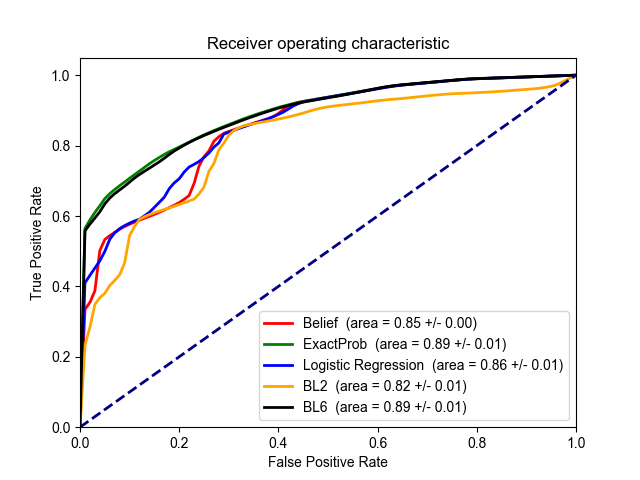

In [93]:
plt.figure()
lw = 2
colors = ['r', 'g', 'b', 'orange', 'k', 'y']

# Plot ROC curve for Belief Model (REACH)
#plt.plot(bel_fpr, bel_tpr, color=colors[0],
#         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
for i, (clf_name, roc_result) in enumerate(roc_results.items()):
    #fpr = roc_result['fpr']
    #tpr = roc_result['tpr']
    roc_auc_arr = roc_aucs[clf_name]
    plt.plot(base_fpr, roc_result, color=colors[i],
         lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                      (clf_name, roc_auc_arr.mean(), roc_auc_arr.std()))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('bel_roc.pdf')
plt.show()


In [44]:
def make_df(d, colname):
    index, raw_cols = zip(*d.items())
    cols = tuple([c for c in raw_cols])
    index_obj = pd.Index(index, name='ev_vector', tupleize_cols=False)
    return pd.DataFrame(cols, columns=[colname], index=index_obj)

df = None
for model_name in ('ExactProb', 'BL2', 'BL6', 'Belief',):
    new_df = make_df(models[model_name].prob_cache, model_name)
    if df is None:
        df = new_df
    else:
        df = df.join(new_df)

# Get probabilities from logistic regression model
lr_probs = {}
for ev_tuple in models[model_name].prob_cache.keys():
    prob = models['Logistic Regression'].predict_proba([ev_tuple])[0][1]
    lr_probs[ev_tuple] = prob
lr_df = make_df(lr_probs, 'LogReg')
df = df.join(lr_df)
        
# Combine with info on frequency
col_names = list(x_df.columns)
freq_vals = {}
for ev_tuple in models[model_name].prob_cache.keys():
    ev_key = frozenset([col_names[ix] for ix, val in enumerate(ev_tuple) if val == 1])
    freq = all_ev_adj_dict.get(ev_key, 0)
    freq_vals[ev_tuple] = freq
ev_df = make_df(freq_vals, 'Freq')
df = df.join(ev_df)
df.sort_values(by='Freq', ascending=False)

,ExactProb,BL2,BL6,Belief,LogReg,Freq
ev_vector,,,,,,
"(0, 1, 0, 0, 0)",0.505240,0.527833,0.505632,0.620891,0.502958,0.538120
"(0, 0, 1, 0, 0)",0.282403,0.403438,0.282506,0.540202,0.296868,0.207090
"(1, 1, 0, 0, 0)",0.905676,0.958270,0.904153,0.977729,0.923937,0.093732
"(0, 1, 1, 0, 0)",0.887925,0.561483,0.891015,0.825686,0.869107,0.059965
"(1, 1, 1, 0, 0)",1.000000,0.833791,1.000000,0.989760,0.987609,0.033974
"(1, 0, 1, 0, 0)",1.000000,1.000000,1.000000,0.972988,0.835208,0.011979
"(0, 0, 0, 1, 0)",0.623950,0.417381,0.614776,0.860360,0.663173,0.009532
"(0, 0, 0, 0, 1)",0.695378,0.201482,0.691710,0.842748,0.531472,0.009521
"(0, 0, 1, 1, 0)",1.000000,0.762500,1.000000,0.935794,0.928157,0.007746


In [259]:
print(classification_report(y_test, y_preds, labels=[0, 1]))

NameError: name 'y_preds' is not defined

In [ ]:
#with open('belief_prec_rec_thresh_auc.pkl', 'rb') as f:
#    bel_prec, bel_rec, bel_thresh, bel_pr_auc = pickle.load(f)


In [ ]:
"""
pr_results = {}
for clf_name, clf_result in clf_results.items():
    precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
    pr_auc = metrics.auc(recall, precision)
    pr_results[clf_name] = {'precision': precision, 'recall': recall,
                            'thresholds': thresholds, 'pr_auc': pr_auc}
"""

<IPython.core.display.Javascript object>


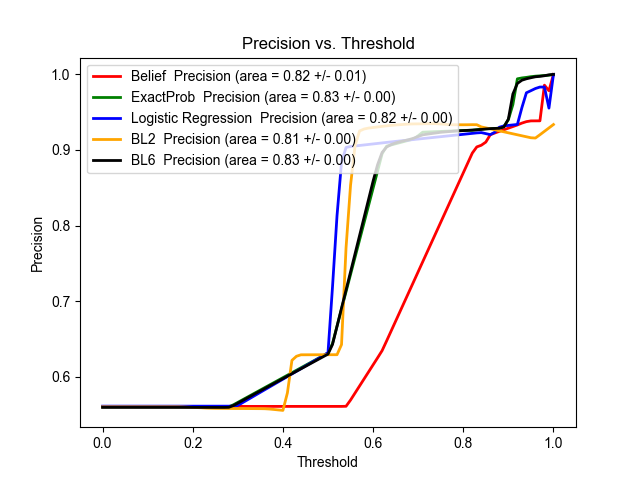

<IPython.core.display.Javascript object>


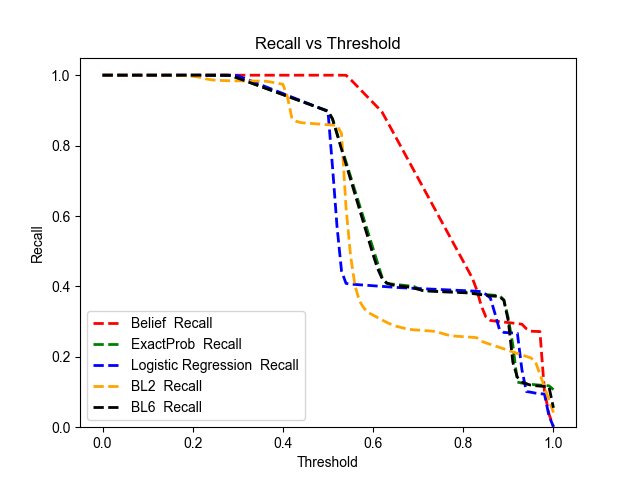

In [45]:

"""
plt.figure()
plt.plot(bel_thresh, bel_prec[: -1], color=colors[0],
             linestyle='-', label="Orig. Belief Precision (area = %0.2f)" % bel_pr_auc)
plt.plot(bel_thresh, bel_rec[: -1], color=colors[0],
             linestyle='--', label="Orig. Belief Recall")
""" 
plt.figure()
for i, (clf_name, prec_result) in enumerate(prec_results.items()):
    pr_auc_arr = pr_aucs[clf_name]
    plt.plot(base_fpr, prec_result, color=colors[i], lw=lw, 
             linestyle='-', 
             label='%s Precision (area = %0.2f +/- %0.2f)' %
                      (clf_name, pr_auc_arr.mean(), pr_auc_arr.std()))

plt.title("Precision vs. Threshold")
plt.ylabel("Precision")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
#plt.ylim([0,1.05])
#plt.savefig('prec_rec.pdf')
plt.show()

plt.figure()
for i, (clf_name, rec_result) in enumerate(rec_results.items()):
    plt.plot(base_fpr, rec_result, color=colors[i], lw=lw,
             linestyle='--',
             label='%s Recall' % clf_name)

plt.title("Recall vs Threshold")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1.05])
#plt.savefig('prec_rec.pdf')
plt.show()

    


In [ ]:
# Associate precision values for the statements at each threshold
# So, if a statement has probability value, check if it is above the threshold, and if so,
# assign it that precision.
list(zip(thresholds, precision))

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Logistic Regression

In [ ]:
logisticRegr.coef_

In [ ]:
sorted(list(zip(x_df.columns, logisticRegr.coef_[0])), key=lambda x: x[1], reverse=True)